# 95/20 Ranking

Estimate top-coded incomes from PUMs data. It sounds like we should pull with a PUMA instead of MET2013, and translate the geography in the analysis.

In [2]:
import pandas

ct_census = pandas.read_csv("too_big/ss14hct.csv") ## Grab for every topcoded state
pums = pandas.read_csv("too_big/usa_00002.csv")
acs_14 = pandas.read_csv("hh_14.csv",encoding = "ISO-8859-1")

In [3]:
census_vars_ct = ["PUMA","ADJINC","SERIALNO","HINCP","WGTP", "PUMA"]
census_vars = ["PUMA","ADJINC","SERIALNO","HINCP","WGTP", "stpuma"]

#bridgeport_pumas = ["00100", "00101", "00102", "00103", "00104", "00105"]

ct_census["bridgeport"] = ct_census["PUMA"].apply(lambda x: ((x>=100) & (x<=105)))

bridgeport_2014 = ct_census[ct_census["bridgeport"]==True][census_vars_ct]
bridgeport_2014["HHINC"] = pandas.to_numeric(bridgeport_2014["HINCP"],errors="coerce")
bridgeport_2014["ADJHH"] = bridgeport_2014.apply(lambda x: (x["ADJINC"]/1000000)*x["HHINC"], axis=1)

In [4]:
def multiply(row,income_col,weight_col,puma_col,tar):
    i = 0
    while i < row[weight_col]:
        new = {puma_col:row[puma_col],income_col:row[income_col]}
        tar.append(new)
        i+=1

def explode_weights(df,income_col, weight_col,puma_col):
    ## Make a list of HHINCOME for calculating
    ## a quantile where each household's HHINCOME
    ## is repeated in the series n times, where
    ## n == weight_col
    tar = []
    df.apply(lambda x: multiply(x,income_col,weight_col,puma_col,tar),axis=1)
    return tar

exploded_bridgeport = explode_weights(bridgeport_2014,"ADJHH","WGTP","PUMA")

In [5]:
pandas.DataFrame(exploded_bridgeport)["ADJHH"].quantile(.95, interpolation="lower")

558969.9774999999

# Hallelujah!

This is the number Brookings had! ~~But from talking to the Census it sounds like they were wrong to adjust income to constant dollars, so we won't do that for our analysis:~~ And they were right to adjust it.  Apparently the ADJINC factor adjusts income to adjust for inflation that took place over the year that the data was being collected: 

_The reason this adjustment is needed is because interviews in the ACS were conducted throughout the year. Application of the adjustment factor will convert dollar amounts to 2006 dollars. Note that the value of ADJUST is the same for all sample cases (its value is 1.015675 for 2006). This is for disclosure avoidance reasons, that is, so that the month of interview cannot be identified by the adjustment factor._

http://www.sdcbidc.iupui.edu/sharing/documents/PUMSInflationAdjustmentdocumentation.pdf

Whether the above makes sense or not, it seems necessary for making our numbers comparable to the ACS calculated numbers. Adjusting after taking the quantile is the same as doing it before, so I'm going to just work the adjustment into my code at the last step.

### Calculate all topcoded 95th percentiles

Load:

* The ACS quantile cut-offs for 2016
* The latest GeoCorr mappings within states containing top-coded CBSAs -- between CBSA & PUMAs

Filter down to just those missing 95th percentile numbers (there are no 'bottom-coded' numbers missing at the 20th percentile)

In [6]:
acs_16 = pandas.read_csv("hh_16.csv", encoding = "ISO-8859-1")
mable = pandas.read_csv("geocorr14_2014.csv", encoding = "ISO-8859-1")[1:] #all.csv", encoding = "ISO-8859-1")[1:]

top_coded = acs_16[acs_16["HD01_VD06"].isnull()]
bottom_coded = acs_16[acs_16["HD01_VD02"].isnull()]

top_coded["States"] = top_coded["GEO.display-label"].apply(lambda x: x.split(',')[1].split()[0].split('-'))

/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


PUMAs are unique within states but not nationally. To handle this, I made my own geography -- STPUMA -- id by concatenating the state's FIPs code with the PUMA.

In [7]:
def digit_str(i,digits):
    s = str(i)
    fill = digits - len(s)
    j = 0
    while j < fill:
        s = '0'+s
        j += 1
    return s

def make_stpuma(st,puma):
    s_puma = digit_str(puma,5)
    return int(str(st)+s_puma)

make_stpuma(9,102)

900102

In [8]:
## Keeping this around/maintained as an error-check that everything is working properly
ct_census['stpuma'] = ct_census.apply(lambda x: make_stpuma(x["ST"],x["PUMA"]),axis=1)

In [9]:
mable['stpuma'] = mable.apply(lambda x: make_stpuma(x["state"],x["puma12"]),axis=1)
mable.head()

,state,puma12,cbsa,stab,cbsaname15,PUMAname,pop14,afact,stpuma
1,01,00100,,AL,,"Lauderdale, Colbert, Franklin & Marion (Northe...",39326.125,0.21,100100
2,01,00100,22520,AL,"Florence-Muscle Shoals, AL (Metro)","Lauderdale, Colbert, Franklin & Marion (Northe...",147639,0.79,100100
3,01,00200,26620,AL,"Huntsville, AL (Metro)",Limestone & Madison (Outer) Counties--Huntsvil...,183944.849,1,100200
4,01,00301,26620,AL,"Huntsville, AL (Metro)",Huntsville (North) & Madison (East) Cities,124425.297,1,100301
5,01,00302,26620,AL,"Huntsville, AL (Metro)",Huntsville City (Central & South),106218.3,1,100302


Go through the topcoded CBSAs, and search the geocorr table for the contingentst pumas. The table also contains a percentage number for how much of the STPUMA is within the CBSA. I store those in a column containing dicts where the keys are the STPUMAs and the values are the percentages.

In [10]:
mable.head()

,state,puma12,cbsa,stab,cbsaname15,PUMAname,pop14,afact,stpuma
1,01,00100,,AL,,"Lauderdale, Colbert, Franklin & Marion (Northe...",39326.125,0.21,100100
2,01,00100,22520,AL,"Florence-Muscle Shoals, AL (Metro)","Lauderdale, Colbert, Franklin & Marion (Northe...",147639,0.79,100100
3,01,00200,26620,AL,"Huntsville, AL (Metro)",Limestone & Madison (Outer) Counties--Huntsvil...,183944.849,1,100200
4,01,00301,26620,AL,"Huntsville, AL (Metro)",Huntsville (North) & Madison (East) Cities,124425.297,1,100301
5,01,00302,26620,AL,"Huntsville, AL (Metro)",Huntsville City (Central & South),106218.3,1,100302


In [11]:
mable["cbsa"] = mable["cbsa"].apply(lambda x : pandas.to_numeric(x,errors="coerce"))
all_pumas = []

def get_pumas(geo_id,geo_corr,rel):
    cbsa = geo_corr[geo_corr["cbsa"] == geo_id] 
    if len(cbsa) == 0:
        print(geo_id)
    target = {}
    for index,row in cbsa.iterrows():
        target[int(row["stpuma"])] = float(row["afact"])
        rel.append(int(row["stpuma"]))
    return target

top_coded["PUMAS"] = top_coded["GEO.id2"].apply(lambda x: get_pumas(x,mable,all_pumas))

640354


/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
state_fips = mable.groupby("stab")[['state']].max()
state_fips.loc["CA"]["state"]

'06'

Functions for fetching the PUMS census files, unzipping them, and storing them in a local file structure. I also process them a bit -- notably by making a STPUMA field -- and then store the all the PUMS entries in a single data frame, which the function get_census_pums returns.

Links to the files can be found on this page: https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_pums_csv_2016&prodType=document

In [13]:
import zipfile,requests,io,os

def fetch_census(x,direct):
    zip_path = "https://www2.census.gov/programs-surveys/acs/data/pums/2016/1-Year/csv_h"+x+".zip"
    r = requests.get(zip_path, stream=True)
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content))
    insert = ""
    if direct is not None:
        insert = direct+'/'
    dir_path = "too_big/"+insert+"2016/csv_h"+x+"/"
    zip_ref.extractall(dir_path)
    os.remove("too_big/"+insert+"2016/csv_h"+x+"/ACS2016_PUMS_README.pdf")

def download_unzip_census(ss_s,direct=None):
    ss_s.apply(lambda x: fetch_census(x.lower(),direct))
    
def make_path(year,state,direct):
    insert = ""
    if direct is not None:
        insert = direct +'/'
    return ("too_big/"+insert+str(year)+"/csv_h"+state+"/ss16h"+state+".csv")
    
def get_census_pums(ss_s,model,direct=None):
    tar = pandas.DataFrame(columns=model.columns)
    for index, s in ss_s.iteritems():
        print(s)
        file = make_path(2016,s.lower(),direct)
        new = pandas.read_csv(file) ## Grab for every topcoded state
        statefip = state_fips.loc[s.upper()]["state"]
        new["stpuma"] = new.apply(lambda x: make_stpuma(x["ST"],x["PUMA"]),axis=1)
        tar = pandas.concat([tar,new])
    return tar

In [14]:
import pickle

# Chris, I didn't end up using your pickle code, but did run with the idea. 
# I think that each cell is executable whether or not you have the pickles I've cached.

def write_obj(obj,filename):
    with open(filename, 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename, 'rb') as handle:
        b = pickle.load(handle)
        return b    

If the PUMs data exploded by weight is available in a pickle, pull that. Otherwise, fetch the PUMS data from all the states that contain topcoded CBSAs, or parts of them. Filter for only stpumas that are part of our topcoded CBSAs. Make a numeric household income column HHINC, then convert the data (exploded_weights) so that each household is listed n times where n = WGTP (the household's weight field). Get that as 'exploded_census'

In [15]:
pop_16 = pandas.read_csv("ACS_16_1YR_B01003.csv",encoding = "ISO-8859-1")
top_coded = top_coded.join(pop_16[["GEO.id2","HD01_VD01"]].set_index("GEO.id2"),on="GEO.id2")
top_coded["us_metro"] = top_coded.apply(lambda x: ("Metro" in x["GEO.display-label"]) & (" PR " not in x["GEO.display-label"]) & (x["HD01_VD01"] >= 500000),axis=1)
top_coded = top_coded[top_coded["us_metro"]==True]

In [16]:
def pums_dataset(tc,exploded_pickle,is_rel,states_dir=None):
    if (os.path.isfile(exploded_pickle)):
        return load_obj(exploded_pickle)
    else:
        s = pandas.Series(tc["States"].sum()).drop_duplicates().sort_values()
        s = s[s!="California"]
        sls = s.tolist()
        print(s)
        if not (os.path.isfile(make_path(2016,sls[0],states_dir))):
            download_unzip_census(s,states_dir)
        census_pums = get_census_pums(s,ct_census,states_dir)
        census_pums["relevant"] = census_pums["stpuma"].apply(lambda x: x in is_rel)
        relevant_census = census_pums[census_pums["relevant"]]
        relevant_census["HHINC"] = pandas.to_numeric(relevant_census["HINCP"],errors="coerce")
        exploded_census = explode_weights(relevant_census,"HHINC","WGTP","stpuma")
        write_obj(exploded_census,exploded_pickle)
        return exploded_census
    
exploded_census = pums_dataset(top_coded,"too_big/exploded_census.pickle",all_pumas)
exploded_census = pandas.DataFrame(exploded_census)

3     CA
2     CT
10    DC
0     MA
12    MD
1     NH
5     NJ
4     NY
6     PA
11    VA
13    WV
dtype: object
CA


/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



CT
DC
MA
MD
NH
NJ
NY
PA
VA
WV


/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
## This is me trying to figure out how many of the top-coded

def count(x):
    if "Metro" in x:
        return True
    else:
        return False
    
top_coded["count"] = top_coded["GEO.display-label"].apply(lambda x: ("Metro" in x))
sample = top_coded[top_coded["count"]]    

x = [['puma','afac']]
for index,value in sample["PUMAS"].iteritems():
    for entry in value:
        x.append([entry,value[entry]])
        
df = pandas.DataFrame(x[1:],columns=x[0])

In [18]:
df.groupby(df['afac']<1).count()

,puma,afac
afac,,
False,369,369
True,16,16


Go through all the topcoded CBSAs, and then construct unweighted/exploded PUMs data for each of them by pulling the appropriate percentage of each component PUMA. (It's possible that income isn't evenly distributed through a PUMA geographically. BUT: This is equivalent to how Brookings did it, and accounts for a very small percentage of the data, and 0 of the Bridgeport-Stamford-Connecticut number.)

Store the constructed data sets in a dict, where the keys are the CBSA's GEO.id2, and the values are the data we've constructed for them.

In [19]:
def get_data(puma,percent,census):
    all_entries = census[census["stpuma"]==puma]
    if percent < 1: 
        s = all_entries.sample(frac=percent,random_state=0)
        return(s)
    return(all_entries)
    
def make_fips_data_dict(df,census,cached_file):
    if (os.path.isfile(cached_file)):
        return load_obj(cached_file)
    else:
        d = {}
        for index, row in df.iterrows():
            tar = pandas.DataFrame(columns=census.columns)
            fip = row["GEO.id2"]
            pumas = row["PUMAS"]
            for p in pumas:
                new = get_data(p,pumas[p],census)
                tar = pandas.concat([tar,new])
            d[fip] = tar
        write_obj(d,cached_file)
        return d
    
fips_data_dict = make_fips_data_dict(top_coded,exploded_census,"too_big/fips_dict.pickle")

Then calculating quantile is as easy as using the pandas quantile function for each CBSA's constructed dataset:

In [20]:
def get_quantile(fips,percent,d):
    data = d[fips]
    return(data["HHINC"].quantile(percent))

def adjinc(ss,year):
    file = make_path(str(year),ss,None)
    new = pandas.read_csv(file)
    return new.loc[0]["ADJINC"]

adj_inc = adjinc("ct",2016)

top_coded["95_Percentile"] = top_coded["GEO.id2"].apply(lambda x: get_quantile(x,.95,fips_data_dict)*adj_inc/1000000)
top_coded["20_Percentile"] = top_coded["GEO.id2"].apply(lambda x: get_quantile(x,.2,fips_data_dict)*adj_inc/1000000)

Calculate the 95/20 ratio for every CBSA in the dataset. I decided to filter down the cities I included, at this stage to only include:

* Metro Areas
* Not Puerto Rico (if you leave it in, these metro areas dominate the top of the list)
* Population >=500,000 (mean population for metro CBSAs that are not in Puerto Rico is ~550,000)

In [21]:
%matplotlib inline
import math

def ninetyfive_twenty(row):
    if row["GEO.id2"] == 640354:
        return None
    if math.isnan(row["HD01_VD06"]):
        return (row["95_Percentile"]/row["20_Percentile"])
    else:
        return (row["HD01_VD06"]/row["HD01_VD02"])
    
inequality_chart = acs_16[["GEO.id2","GEO.display-label","HD01_VD02","HD01_VD06"]].join(top_coded[["GEO.id2","95_Percentile","20_Percentile"]].set_index("GEO.id2"),on="GEO.id2")    
inequality_chart[9520] = inequality_chart.apply(lambda x: ninetyfive_twenty(x),axis=1)

In [22]:
inequality_chart.sort_values(9520,ascending=False) ## join hte mabel population totals

,GEO.id2,GEO.display-label,HD01_VD02,HD01_VD06,95_Percentile,20_Percentile,9520
542,32420,"Mayagüez, PR Metro Area",3523.0,75588.0,NaN,NaN,21.455578
773,42180,"Santa Isabel, PR Micro Area",4404.0,83867.0,NaN,NaN,19.043370
358,24900,"Greenwood, MS Micro Area",9325.0,145151.0,NaN,NaN,15.565791
823,44260,"Starkville, MS Micro Area",10752.0,162460.0,NaN,NaN,15.109747
605,35060,"Natchitoches, LA Micro Area",10258.0,151224.0,NaN,NaN,14.742055
743,40820,"Ruston, LA Micro Area",11717.0,168941.0,NaN,NaN,14.418452
120,14860,"Bridgeport-Stamford-Norwalk, CT Metro Area",32385.0,NaN,485657.416,34257.9920,14.176471
691,38660,"Ponce, PR Metro Area",5443.0,76358.0,NaN,NaN,14.028661
328,23700,"Gallup, NM Micro Area",9105.0,126665.0,NaN,NaN,13.911587
107,14380,"Boone, NC Micro Area",11673.0,161786.0,NaN,NaN,13.859848


In [23]:
def consolidate(row,col_tuple):
    first = row[col_tuple[0]]
    if math.isnan(first):
        return row[col_tuple[1]]
    else:
        return first

to_export = inequality_chart
to_export["95"] = to_export.apply(lambda x: consolidate(x,("HD01_VD06","95_Percentile")),axis=1)
to_export["20"] = to_export.apply(lambda x: consolidate(x,("HD01_VD02","20_Percentile")),axis=1)

In [24]:
to_export = to_export.join(pop_16[["GEO.id2","HD01_VD01"]].set_index("GEO.id2"),on="GEO.id2")
to_export = to_export.rename(columns={"HD01_VD01":"pop_estimate"})
to_export = to_export[to_export["pop_estimate"]>=500000]
to_export = to_export[["GEO.id2","GEO.display-label","95","20",9520,"pop_estimate"]].sort_values(9520,ascending=False).reset_index()
to_export.to_csv("95-20-MSA.csv")
to_export

,index,GEO.id2,GEO.display-label,95,20,9520,pop_estimate
0,120,14860,"Bridgeport-Stamford-Norwalk, CT Metro Area",485657.41600,32385.0,14.176471,944177.0
1,617,35620,"New York-Newark-Jersey City, NY-NJ-PA Metro Area",304291.57600,24732.0,11.984127,20153634.0
2,766,41860,"San Francisco-Oakland-Hayward, CA Metro Area",397594.22480,32235.0,10.961111,4679166.0
3,507,31080,"Los Angeles-Long Beach-Anaheim, CA Metro Area",271041.17200,24426.0,10.760000,13310447.0
4,611,35380,"New Orleans-Metairie, LA Metro Area",194587.00000,18379.0,10.587464,1268883.0
5,768,41940,"San Jose-Sunnyvale-Santa Clara, CA Metro Area",430139.31720,39133.0,10.412195,1978816.0
6,559,33100,"Miami-Fort Lauderdale-West Palm Beach, FL Metr...",209733.00000,20387.0,10.287585,6066387.0
7,546,32580,"McAllen-Edinburg-Mission, TX Metro Area",143137.00000,13966.0,10.248962,849843.0
8,253,20500,"Durham-Chapel Hill, NC Metro Area",228650.00000,22462.0,10.179414,559535.0
9,109,14460,"Boston-Cambridge-Newton, MA-NH Metro Area",300765.01800,29225.0,9.851485,4794447.0


# How accurate?

In [25]:
pop_16 = pandas.read_csv("ACS_16_1YR_B01003.csv",encoding = "ISO-8859-1")
to_test = acs_16.join(pop_16[["GEO.id2","HD01_VD01"]].set_index("GEO.id2"),on="GEO.id2")
to_test = to_test.rename(columns={"HD01_VD02":"Census_20","HD01_VD06":"Census_95","HD01_VD01":"Census_Pop"})
to_test = to_test[["GEO.id","GEO.id2","GEO.display-label","Census_20","Census_95","Census_Pop"]][(to_test["Census_Pop"]>500000)]

In [26]:
to_test[to_test["GEO.id2"]==14860]

,GEO.id,GEO.id2,GEO.display-label,Census_20,Census_95,Census_Pop
120,310M300US14860,14860,"Bridgeport-Stamford-Norwalk, CT Metro Area",32385.0,NaN,944177.0


In [27]:
def quantiles_tens(series):
    container = {}
    i = .1
    while i < 1:
        container[i] = series.quantile(i)
        i = round(i+.1,2)
    return container

def assign_bin(x,bins):
    for k in bins.keys():
        if x < bins[k]:
            return k
    return 1

tens = quantiles_tens(to_test["Census_Pop"])
to_test["bin"] = to_test["Census_Pop"].apply(lambda x: assign_bin(x,tens))

In [28]:
def try_sample(x,m):
    while True:
        if m==0:
            return None
        try:
            return x.sample(n=m)
        except:
            m = m-1

all_pop_sample = to_test[to_test["Census_95"]>0].groupby("bin").apply(lambda x: try_sample(x,5))
all_pop_sample = all_pop_sample.reset_index(drop=True)
tens

{0.1: 564633.8,
 0.2: 650355.4,
 0.3: 751787.3999999999,
 0.4: 861755.4,
 0.5: 992605.0,
 0.6: 1295086.4,
 0.7: 2044338.4,
 0.8: 2467702.6000000006,
 0.9: 4668588.600000001}

In [29]:
# To look at accuracy of estimates of cities comparable to Bridgeport in size, let's 
# look at the 20 closest cities above and below Bridgeport in population

sorted_test = to_test.sort_values("Census_Pop").reset_index()
bridgeport_index = sorted_test.loc[sorted_test["GEO.id2"]==14860].index[0]

bridgeport_sample = sorted_test[sorted_test["Census_95"]>0][(bridgeport_index-10):(bridgeport_index+10)]

In [30]:
bridgeport_sample["States"] = bridgeport_sample["GEO.display-label"].apply(lambda x: x.split(',')[1].split()[0].split('-'))
all_sample_pumas = []
bridgeport_sample["PUMAS"] = bridgeport_sample["GEO.id2"].apply(lambda x: get_pumas(x,mable,all_sample_pumas))

In [31]:
exploded_sample = pums_dataset(bridgeport_sample,"too_big/test/exploded_sample.pickle",all_sample_pumas,"test")
exploded_sample = pandas.DataFrame(exploded_sample)

18    AL
14    AZ
4     CA
1     CT
13    HI
8     IA
21    LA
9     MA
15    MI
7     NE
6     NM
3     NY
12    OK
5     SC
2     TN
0     TX
19    UT
dtype: object
AL


/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



AZ
CA
CT
HI
IA
LA
MA
MI
NE
NM
NY
OK
SC
TN
TX
UT


/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
exploded_sample.shape

(9083285, 2)

In [33]:
fips_sample_dict = make_fips_data_dict(bridgeport_sample,exploded_sample,"too_big/test/fips_dict.pickle")
fips_sample_dict.keys()

dict_keys([32580, 35300, 28940, 10580, 12540, 24860, 10740, 36540, 49340, 23420, 46140, 46520, 46060, 24340, 40380, 15380, 13820, 41620, 25540, 35380])

In [34]:
bridgeport_sample["Calculated_95"] = bridgeport_sample["GEO.id2"].apply(lambda x: get_quantile(x,.95,fips_sample_dict)*adj_inc/1000000)
bridgeport_sample["Calculated_20"] = bridgeport_sample["GEO.id2"].apply(lambda x: get_quantile(x,.2,fips_sample_dict)*adj_inc/1000000)

In [35]:
bridgeport_sample["census_ratio"] = bridgeport_sample.apply(lambda x: x["Census_95"]/x["Census_20"],axis=1)
bridgeport_sample["calculated_ratio"] = bridgeport_sample.apply(lambda x: x["Calculated_95"]/x["Calculated_20"],axis=1)

count    20.000000
mean      0.363109
std       0.458287
min      -0.567305
25%       0.033179
50%       0.395137
75%       0.564775
max       1.466416
Name: error, dtype: float64


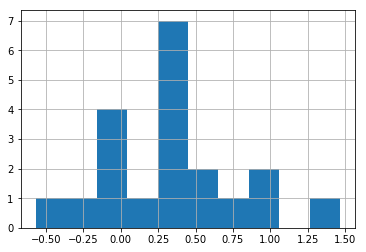

In [36]:
bridgeport_sample["error"] = bridgeport_sample.apply(lambda x: x["calculated_ratio"]-x['census_ratio'],axis=1)
print(bridgeport_sample["error"].describe())
bridgeport_sample["error"].hist()

In [37]:
for index,row in bridgeport_sample[bridgeport_sample["error"]>=1].iterrows():
    print(row["error"])
    print(row["GEO.display-label"])
    print(row["PUMAS"])

1.4664163761508906
Fresno, CA Metro Area
{601901: 1.0, 601902: 1.0, 601903: 1.0, 601904: 1.0, 601905: 1.0, 601906: 1.0, 601907: 1.0}


Only 1 out of the 20 cities sized similarly to Bridgeport are off by more than 1 ratio point, Bridgeport is over 2 ratio points above the city with the second-highest 95/20 ratio. The city with the second-highest 95/20 ratio is also topcoded, so maybe I should do the same thing with cities of that size, but I think this check at least suggests we're on the right track.

I could also perform this analysis again against a wider variety of cities? 

# Quintile Wages 2007-2016

Fetch mean wages 2011-2016 for the bottom 20% and the top 5% of the US and of Bridgeport-Stamford-Norwalk from the Census API -- American Commmunity Survey 1-year

In [38]:
import pandas,json,urllib,re,numpy,time

base = "https://api.census.gov/data/"


fields = ["B19081_001E","B19081_006E"]
year_range = [2012,2016]

def construct_quint_url(year,geo_type,geo_code,quints):
    url = base
    if (year == 2016):
        url += str(year)+"/acs/acs1?get="
    else:
        url += str(year)+"/acs1?get="
    i=1 
    for quint in quints:
        url += quint+"&"
        i+=1
    url+= "for="+geo_type+geo_code
    return(url)

def url_to_data(url):
    req = urllib.request.Request(url)
    req.add_header('User-agent', 'Mozilla 5.10')
    res = urllib.request.urlopen(req)
    data = json.load(res)
    return data

def make_long_data(date_r, geo_type, geo_code,quints):
    year = date_r[0]
    tar = [fields+["geo","year"]]
    while year <= date_r[1]:
        print(construct_quint_url(year,geo_type,geo_code,quints))
        new_row = url_to_data(construct_quint_url(year,geo_type,geo_code,quints))[1]
        new_row.append(year)
        tar.append(new_row)
        year += 1
    return tar

bridgeport_data = make_long_data(year_range,"metropolitan%20statistical%20area/micropolitan%20statistical%20area",":14860",fields)
national_data = make_long_data(year_range,"us","",fields)

https://api.census.gov/data/2012/acs1?get=B19081_001E&B19081_006E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:14860
https://api.census.gov/data/2013/acs1?get=B19081_001E&B19081_006E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:14860
https://api.census.gov/data/2014/acs1?get=B19081_001E&B19081_006E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:14860
https://api.census.gov/data/2015/acs1?get=B19081_001E&B19081_006E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:14860
https://api.census.gov/data/2016/acs/acs1?get=B19081_001E&B19081_006E&for=metropolitan%20statistical%20area/micropolitan%20statistical%20area:14860
https://api.census.gov/data/2012/acs1?get=B19081_001E&B19081_006E&for=us
https://api.census.gov/data/2013/acs1?get=B19081_001E&B19081_006E&for=us
https://api.census.gov/data/2014/acs1?get=B19081_001E&B19081_006E&for=us
https://api.census.gov/data/2015/acs1?get=B19081_001E&B19

In [39]:
#ct_data = make_long_data(year_range,"state",":009",fields)
bridgeport_data

[['B19081_001E', 'B19081_006E', 'geo', 'year'],
 ['15822', '768432', '14860', 2012],
 ['15817', '781504', '14860', 2013],
 ['16741', '822518', '14860', 2014],
 ['16544', '777935', '14860', 2015],
 ['18159', '813869', '14860', 2016]]

In [40]:
bp_df = pandas.DataFrame(bridgeport_data[1:],columns = bridgeport_data[0])
nat_df = pandas.DataFrame(national_data[1:],columns = national_data[0])

bp_df = bp_df.rename(columns={"B19081_001E":"20","B19081_006E":"95"})
nat_df = nat_df.rename(columns={"B19081_001E":"20","B19081_006E":"95"})

Import the manually-collected data from before 2011, taken from the American Community Survey "Fact Finder" website, join with our API data.

In [41]:
bp_df = bp_df[bp_df.columns[bp_df.columns!="geo"]]
nat_df = nat_df[nat_df.columns[nat_df.columns!="geo"]]
df = bp_df.join(nat_df.set_index("year"),on="year",lsuffix="_BP",rsuffix="_US")
earlier_years = pandas.read_csv("excel/pre2011.csv")
join_df = earlier_years.rename(columns = {"BP_20":"20_BP","BP_95":"95_BP","US_20":"20_US","US_95":"95_US"})
join_df = join_df[["year","20_BP","95_BP","20_US","95_US"]]

df = pandas.concat([join_df,df]).sort_values("year").reset_index(drop=True)

/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


Adjust for inflation, using the Consumer Price Index.

In [42]:
cpi = pandas.read_csv("excel/consumer_price_index.csv").set_index("year")
to_adjust = df.join(cpi,on="year")
cols = to_adjust.columns
to_adjust[cols] = to_adjust[cols].apply(pandas.to_numeric, errors='coerce')
to_adjust

,20_BP,20_US,95_BP,95_US,year,CPI
0,18166,11797,743831,311427,2007,304.6
1,16701,11984,822708,322881,2008,316.3
2,16145,11467,700068,305979,2009,315.2
3,14933,11307,685431,299770,2010,320.3
4,15286,11186,669517,311995,2011,330.5
5,15822,11361,768432,319918,2012,337.3
6,15817,11544,781504,339950,2013,342.2
7,16741,11859,822518,346522,2014,347.8
8,16544,12365,777935,364563,2015,348.2
9,18159,12691,813869,378330,2016,352.6


In [43]:
# Inflation-adjusted estimate = 1995 estimate * (2016 CPI-U-RS / 1995 CPI-U-RS)
#                        = 1995 estimate * (352.6 / 225)

adjustable_cols = ["20_BP", "20_US", "95_BP", "95_US"]

def adjust_dollars(row,base_cpi):
    factor = base_cpi/row["CPI"]
    tar = {}
    for x in adjustable_cols:
        tar[x] = row[x]*factor
    tar["year"] = row["year"]
    return tar

adjusted = to_adjust.copy()

adjusted["2016_dollars"] = adjusted.apply(lambda x: adjust_dollars(x,cpi.loc[2016]["CPI"]),axis=1)
adjusted["2007_dollars"] = adjusted.apply(lambda x: adjust_dollars(x,cpi.loc[2007]["CPI"]),axis=1)

In [44]:
sixteen_dollars = pandas.DataFrame(adjusted["2016_dollars"].tolist())
seven_dollars = pandas.DataFrame(adjusted["2007_dollars"].tolist())

In [45]:
sixteen_dollars

,20_BP,20_US,95_BP,95_US,year
0,21028.665791,13656.015102,861046.653316,360502.824032,2007.0
1,18617.681315,13359.337338,917125.642744,359936.264938,2008.0
2,18060.682107,12827.614848,783134.444162,342284.883883,2009.0
3,16438.887918,12447.231346,754551.890727,329999.694037,2010.0
4,16308.150076,11933.989713,714286.518003,332857.600605,2011.0
5,16539.689297,11876.337385,803288.239549,334429.548770,2012.0
6,16297.703682,11894.840444,805255.144360,350281.618936,2013.0
7,16972.043128,12022.666475,833869.599770,351304.362277,2014.0
8,16753.056864,12521.249282,787765.310167,369169.769673,2015.0
9,18159.000000,12691.000000,813869.000000,378330.000000,2016.0


In [46]:
to_adjust

,20_BP,20_US,95_BP,95_US,year,CPI
0,18166,11797,743831,311427,2007,304.6
1,16701,11984,822708,322881,2008,316.3
2,16145,11467,700068,305979,2009,315.2
3,14933,11307,685431,299770,2010,320.3
4,15286,11186,669517,311995,2011,330.5
5,15822,11361,768432,319918,2012,337.3
6,15817,11544,781504,339950,2013,342.2
7,16741,11859,822518,346522,2014,347.8
8,16544,12365,777935,364563,2015,348.2
9,18159,12691,813869,378330,2016,352.6


Zero-index the data to track percent change since 2007.

In [47]:
def index(row,base_row):
    tar = {}
    for x in adjustable_cols:
        tar[x] = ((row[x]/base_row[x]) * 100) - 100
    tar["year"] = row["year"]
    return(tar)

base_index = adjusted.loc[0]
adjusted["index"] = adjusted.apply(lambda x: index(x,base_index),axis=1)

       20_BP     20_US      95_BP      95_US  year
0   0.000000  0.000000   0.000000   0.000000  2007
1  -8.064516  1.585149  10.604156   3.677908  2008
2 -11.125179 -2.797321  -5.883460  -1.749367  2009
3 -17.796983 -4.153598  -7.851246  -3.743092  2010
4 -15.853793 -5.179283  -9.990710   0.182386  2011
5 -12.903226 -3.695855   3.307337   2.726482  2012
6 -12.930750 -2.144613   5.064726   9.158808  2013
7  -7.844325  0.525557  10.578613  11.269094  2014
8  -8.928768  4.814783   4.584912  17.062104  2015
9  -0.038534  7.578198   9.415848  21.482723  2016


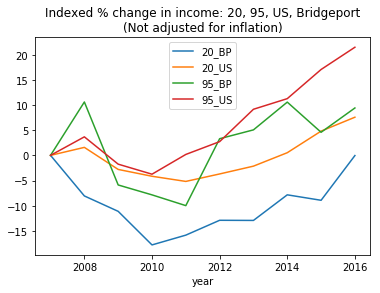

In [48]:
current_dollars_indexed = pandas.DataFrame(adjusted["index"].tolist())
print(current_dollars_indexed)
current_dollars_indexed.set_index("year").plot(title="Indexed % change in income: 20, 95, US, Bridgeport\n(Not adjusted for inflation)")

It turns out things look different if we adjust the indexed analysis for inflation! It doesn't matter whether we index by the beginning of our data set or the end, which I expected, which is good.

       20_BP      20_US      95_BP     95_US    year
0   0.000000   0.000000   0.000000  0.000000  2007.0
1 -11.465228  -2.172506   6.512886 -0.157158  2008.0
2 -14.113990  -6.066193  -9.048547 -5.053481  2009.0
3 -21.826291  -8.851658 -12.368060 -8.461274  2010.0
4 -22.448004 -12.610014 -17.044388 -7.668518  2011.0
5 -21.346939 -13.032189  -6.707931 -7.232475  2012.0
6 -22.497681 -12.896695  -6.479499 -2.835264  2013.0
7 -19.290918 -11.960653  -3.156281 -2.551564  2014.0
8 -20.332288  -8.309641  -8.510729  2.404127  2015.0
9 -13.646447  -7.066594  -5.479105  4.945086  2016.0


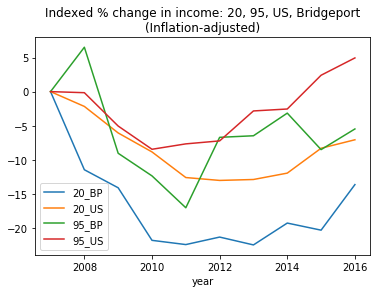

In [49]:
base_index = seven_dollars.loc[0]
seven_dollars["index"] = seven_dollars.apply(lambda x: index(x,base_index),axis=1)

seven_dollars_indexed = pandas.DataFrame(seven_dollars["index"].tolist())
print(seven_dollars_indexed)
seven_dollars_indexed.set_index("year").plot(title="Indexed % change in income: 20, 95, US, Bridgeport\n(Inflation-adjusted)")

       20_BP      20_US      95_BP     95_US    year
0   0.000000   0.000000   0.000000  0.000000  2007.0
1 -11.465228  -2.172506   6.512886 -0.157158  2008.0
2 -14.113990  -6.066193  -9.048547 -5.053481  2009.0
3 -21.826291  -8.851658 -12.368060 -8.461274  2010.0
4 -22.448004 -12.610014 -17.044388 -7.668518  2011.0
5 -21.346939 -13.032189  -6.707931 -7.232475  2012.0
6 -22.497681 -12.896695  -6.479499 -2.835264  2013.0
7 -19.290918 -11.960653  -3.156281 -2.551564  2014.0
8 -20.332288  -8.309641  -8.510729  2.404127  2015.0
9 -13.646447  -7.066594  -5.479105  4.945086  2016.0


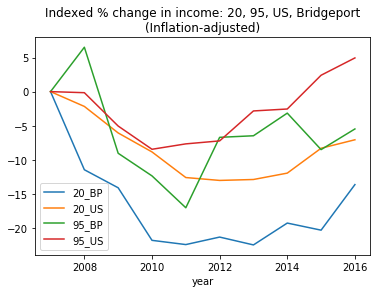

In [50]:
sixteen_base_index = sixteen_dollars.loc[0]
      
sixteen_dollars["index"] = sixteen_dollars.apply(lambda x: index(x,sixteen_base_index),axis=1)

sixteen_dollars_indexed = pandas.DataFrame(sixteen_dollars["index"].tolist())
print(sixteen_dollars_indexed)
sixteen_dollars_indexed.set_index("year").plot(title="Indexed % change in income: 20, 95, US, Bridgeport\n(Inflation-adjusted)")

In [51]:
import json

# export for the graphic
sixteen_j = json.loads(sixteen_dollars_indexed.set_index("year").transpose().to_json(orient='split'))

In [52]:
sixteen_dollars_indexed.set_index("year").transpose().to_json('indexed_means.json',orient='split')

In [53]:
sixteen_dollars_indexed.set_index("year").to_csv("indexed_means.csv")

# State-Level 95/20

Some of the state top-5% income cut-offs are also top-coded

In [54]:
import pandas
state_acs = pandas.read_csv("state_hh_16.csv")

In [55]:
top_state = state_acs[state_acs["HD01_VD06"].isnull()]
top_state

,GEO.id,GEO.id2,GEO.display-label,HD01_VD02,HD02_VD02,HD01_VD03,HD02_VD03,HD01_VD04,HD02_VD04,HD01_VD05,HD02_VD05,HD01_VD06,HD02_VD06
4,0400000US06,6,California,26697,183,52331,208,85740,375,140784,465,NaN,NaN
6,0400000US09,9,Connecticut,29917,766,56803,903,92131,1060,146556,1434,NaN,NaN
8,0400000US11,11,District of Columbia,20813,1543,55236,3374,100336,2633,170657,4812,NaN,NaN
20,0400000US24,24,Maryland,32691,672,61983,611,97193,851,150178,1245,NaN,NaN
21,0400000US25,25,Massachusetts,28024,700,57438,786,95015,800,149866,1397,NaN,NaN
30,0400000US34,34,New Jersey,29167,557,58784,674,96144,928,154189,1324,NaN,NaN
32,0400000US36,36,New York,23187,310,48100,521,80699,409,132453,858,NaN,NaN
46,0400000US51,51,Virginia,28532,601,53162,733,85471,567,136562,959,NaN,NaN


In [57]:
state_fips_dict = {6:"ca",9:"ct",11:"dc",24:"md",25:"ma",34:"nj",36:"ny",51:"va"}
top_state["ss"] = top_state["GEO.id2"].apply(lambda x: state_fips_dict[x])


def make_state_files(tc_states):
    states = tc_states["ss"]
    sls = states.tolist()
    if not (os.path.isfile(make_path(2016,sls[0],"state"))):
        download_unzip_census(states,"state")
    for s in sls:
        print(s)
        filepath = make_path(2016,s,"state")
        state_data = pandas.read_csv(filepath)
        state_data["HHINC"] = pandas.to_numeric(state_data["HINCP"],errors="coerce")
        print("got state_data, exploding ...")
        state_data = explode_weights(state_data,"HHINC","WGTP","PUMA")
        write_obj(state_data,"too_big/state/exploded/"+s+".pickle")
        
make_state_files(top_state)

/home/cimar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


ca
got state_data, exploding ...
ct
got state_data, exploding ...
dc
got state_data, exploding ...
md
got state_data, exploding ...
ma
got state_data, exploding ...
nj
got state_data, exploding ...
ny
got state_data, exploding ...
va
got state_data, exploding ...


In [ ]:
#if not (os.path.isfile("too_big/state/exploded/"+state_list[0]+".pickle")):
#    make_state_files(top_state)

def make_state_path(ss):
    return ("too_big/state/exploded/"+ss+".pickle")
    
def get_state_quantile(ss,percent):
    data = load_obj(make_state_path(ss))
    return pandas.DataFrame(data)["HHINC"].quantile(percent)
    
    
top_state["95_Percentile"] = top_state["ss"].apply(lambda x: get_state_quantile(x,.95))
top_state["20_Percentile"] = top_state["ss"].apply(lambda x: get_state_quantile(x,.2))

In [ ]:
state_chart = state_acs.join(top_state.set_index("GEO.id2")[["95_Percentile","20_Percentile"]],on="GEO.id2")

state_chart[9520] = state_chart.apply(lambda x: ninetyfive_twenty(x),axis=1)
state_chart["95"] = state_chart.apply(lambda x: consolidate(x,("HD01_VD06","95_Percentile")),axis=1)
state_chart["20"] = state_chart.apply(lambda x: consolidate(x,("HD01_VD02","20_Percentile")),axis=1)

In [ ]:
state_chart[["GEO.id2","GEO.display-label","95","20",9520]].sort_values(9520,ascending=False).reset_index(drop=True)#.to_csv("states_9520.csv")